In [1]:
import pandas as pd
import nltk
import re

reply_df = pd.read_csv('./merge_comments_data.csv')
reply_df

,Comment,Target
0,측면 추돌시 전복되기 쉬운차는 맞는것 같지만... 일상 주행시에 코너 돌때 전복될 ...,0
1,지옥참밀도,0
2,진짜 꿀 가득 차있는거 맛있어 보인다...,0
3,와 수준진짜 높아졌네...차 디자인도 좋고,0
4,응 안사,0
...,...,...
16445,빠순이들아 쉴드치면 더욕먹는다 ㅉㅉ 민혁은 사기꾼 아들이네 ㅉㅉ 돈갚아라 나쁜넘아,1
16446,사생들아. 저거보고 나도 장애 가져서 빅뱅 좋다고 하면 너만의 선물 줄거란 기대로 ...,1
16447,북에서는 자유롭게 배타고 오드만 왜 우린 일본도 못가냐 재앙아?,1
16448,게이야 고려시대는 꽤 괜찮은 중세시대였다~그리고 조선도 태종 까지는 괜찮은 편이었는...,1


In [2]:
korean_stopwords = set([
    '이', '그', '저', '것', '들', '의', '를', '은', '는', '에', '와', '과', '도', '으로', '까지', '부터', '다시', '번', '만', '할', '한다', '그리고'
])

# 데이터 전처리 함수 정의
def preprocess_text(text):
    # 특수 문자 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # 형태소 분석
    words = text.split()
    # 불용어 제거
    text = ' '.join([word for word in words if word not in korean_stopwords])
    return text

In [3]:
# 데이터 전처리 적용
reply_df['Comment'] = reply_df['Comment'].apply(preprocess_text)
reply_df['Comment'].replace('', pd.NA, inplace=True)
reply_df.dropna(subset=['Comment'], inplace=True)

C:\Users\qortl\AppData\Local\Temp\ipykernel_19104\4115863815.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reply_df['Comment'].replace('', pd.NA, inplace=True)


In [4]:
reply_df

,Comment,Target
0,측면 추돌시 전복되기 쉬운차는 맞는것 같지만 일상 주행시에 코너 돌때 전복될 일은 ...,0
1,지옥참밀도,0
2,진짜 꿀 가득 차있는거 맛있어 보인다,0
3,수준진짜 높아졌네차 디자인도 좋고,0
4,응 안사,0
...,...,...
16445,빠순이들아 쉴드치면 더욕먹는다 민혁은 사기꾼 아들이네 돈갚아라 나쁜넘아,1
16446,사생들아 저거보고 나도 장애 가져서 빅뱅 좋다고 하면 너만의 선물 줄거란 기대로 장...,1
16447,북에서는 자유롭게 배타고 오드만 왜 우린 일본도 못가냐 재앙아,1
16448,게이야 고려시대는 꽤 괜찮은 중세시대였다그리고 조선도 태종 까지는 괜찮은 편이었는데...,1


In [5]:
reply_df.Target.value_counts()

Target
1    8207
0    8151
Name: count, dtype: int64

In [6]:
# 데이터 샘플링
profanity = reply_df[reply_df['Target'] == 1].sample(8151, random_state=124)
normal = reply_df[reply_df['Target'] == 0]
reply_df = pd.concat([profanity, normal]).reset_index(drop=True)

In [7]:
from sklearn.model_selection import train_test_split

features, targets = reply_df.Comment, reply_df.Target

X_train, X_test, y_train, y_test = \
train_test_split(features, targets, stratify=targets, test_size=0.2, random_state=124)

y_train.value_counts()

Target
1    6521
0    6520
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

parameters = {
    'count_vectorizer__ngram_range': [
        (1, 1), (1, 2), (1, 3), (2, 2), (2, 3)
    ], 
    'multinomial_NB__alpha': [
        0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
    ]   
}

m_nb_pipe = Pipeline([('count_vectorizer', CountVectorizer()), 
                      ('multinomial_NB', MultinomialNB())])
g_m_nb = GridSearchCV(
    m_nb_pipe, param_grid=parameters, cv=10, refit=True, return_train_score=True, n_jobs=-1)

In [9]:
g_m_nb.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('multinomial_NB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'count_vectorizer__ngram_range': [(1, 1), (1, 2),
                                                           (1, 3), (2, 2),
                                                           (2, 3)],
                         'multinomial_NB__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                   0.7, 0.8, 0.9, 1]},
             return_train_score=True)

In [10]:
m_nb_result_df = pd.DataFrame(g_m_nb.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(m_nb_result_df)

m_nb = g_m_nb.best_estimator_

,params,mean_test_score,rank_test_score
0,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.704392,23
1,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.706846,11
2,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.707766,7
3,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.707460,8
4,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.708457,6
5,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.709070,2
6,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.709377,1
7,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.708840,3
8,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.708610,5
9,"{'count_vectorizer__ngram_range': (1, 1), 'mul...",0.708687,4


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# 정밀도, 재현율, F1 score는 다중 분류에서 각각의 확률값의 평균을 구해서 나타내야 한다.
# 이 때, macro 방식과, micro 방식이 대표적이다.
# macro: 평균을 낸 뒤, 그 평균의 다시 평균을 구하는 방식(샘플 수는 신경쓰지 않는다).
# micro: 샘플 수를 전체 합하고 전체 개수도 전체 합해서 나눠주는 방식(샘플 수를 신경쓴다).
# 타겟 데이터의 비중이 많이 차이난다면, micro방식을 사용하는 것이 바람직하다.
def get_evaluation(y_test, prediction, classifier=None, X_test=None):
#     오차 행렬
    confusion = confusion_matrix(y_test, prediction)
#     정확도
    accuracy = accuracy_score(y_test , prediction)
#     정밀도
    precision = precision_score(y_test , prediction, average='micro')
#     재현율
    recall = recall_score(y_test , prediction, average='micro')
#     F1 score
    f1 = f1_score(y_test, prediction, average='micro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    print("#" * 80)
    
    if classifier is not None and  X_test is not None:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

In [12]:
prediction = m_nb.predict(X_train)

오차 행렬
[[6300  220]
 [  81 6440]]
정확도: 0.9769, 정밀도: 0.9769, 재현율: 0.9769, F1: 0.9769
################################################################################


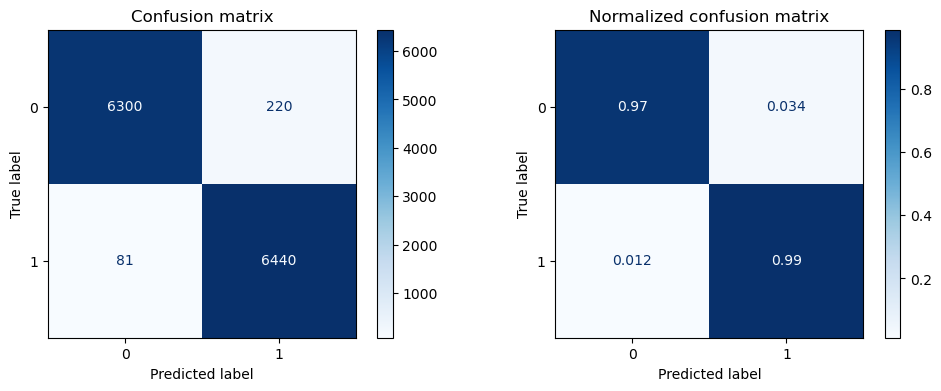

In [13]:
get_evaluation(y_train, prediction, m_nb, X_train)

In [14]:
prediction = m_nb.predict(X_test)

오차 행렬
[[1001  630]
 [ 306 1324]]
정확도: 0.7130, 정밀도: 0.7130, 재현율: 0.7130, F1: 0.7130
################################################################################


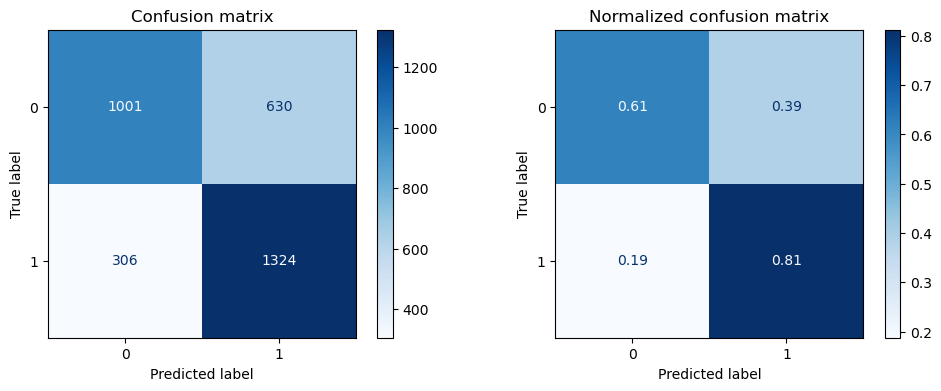

In [15]:
get_evaluation(y_test, prediction, m_nb, X_test)

In [16]:
# %pip install joblib

In [17]:
# %pip install pickle

In [18]:
# import pickle
# import joblib

# # joblib.dump(m_nb, './commentai.pkl')
# with open('commentai.pkl', 'wb') as f:
#     pickle.dump(m_nb, f)

In [21]:
m_nb.predict(['씨발'])

array([1], dtype=int64)